In [1]:
import os
from enum import Enum
import numpy as np
import scipy.io.arff
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import librosa

In [2]:
class Genres(Enum): 
    BLUES=0; CLASSICAL=1; COUNTRY=2; DISCO=3; HIPHOP=4; JAZZ=5; METAL=6; POP=7; REGGAE=8; ROCK=9 

genres = "BLUES CLASSICAL COUNTRY DISCO HIPHOP JAZZ METAL POP REGGAE ROCK".split(" ")

In [3]:
data_name = "genres_mfcc"
datafile = "../{}.arff".format(data_name)
data, meta = scipy.io.arff.loadarff(datafile)

In [4]:
## loading file names from ARFF
fs = []
with open(datafile, 'r') as f:
    for line in f:
        if "filename" in line:
            fs.append(line.strip().split(" ")[2])

In [5]:
X = []
Y = [] 
label_idx = len(data[0])-1
for row in data:
    X.append(list(row)[:label_idx])
    Y.append(int(list(row)[label_idx:][0]))
X = np.array(X)
Y = np.array(Y)
fs = np.array(fs)
print("\tX: {}".format(X.shape))
print("\tY: {}".format(Y.shape))
print("\tFs: {}".format(fs.shape))

	X: (1000, 52)
	Y: (1000,)
	Fs: (1000,)


In [6]:
np.savez("{}_data.npz".format(data_name), X=X, Y=Y, fs=fs)

In [7]:
data = np.load("{}_data.npz".format(data_name))
X = data["X"]
Y = data["Y"]
fs = data["fs"]
print("\t{}".format(data["X"].shape))
print("\t{}".format(data["Y"].shape))
print("\t{}".format(data["fs"].shape))

	(1000, 52)
	(1000,)
	(1000,)


## Run TSNE on Data

In [8]:
from sklearn import manifold

Runing TSNE iteration 1 with LR 100...
Runing TSNE iteration 2 with LR 500...
Done


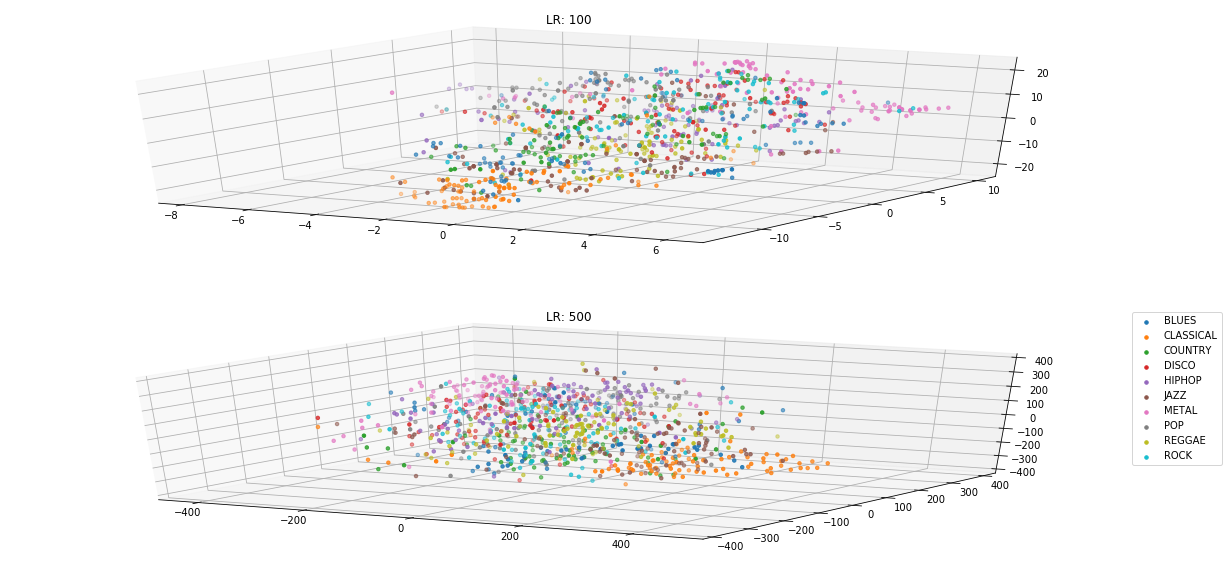

In [14]:
n_components = 3
p = 25
learning_rates = [100, 500]
n_iter = 5000

fig = plt.figure(figsize=(10, 10))
cmap = plt.get_cmap("tab10")

for i, l in enumerate(learning_rates):
    print("Runing TSNE iteration {} with LR {}...".format(i+1, l))
    tsne = manifold.TSNE(n_components=n_components, init="random", random_state=0, perplexity=p, learning_rate=l, n_iter=n_iter)
    Y_tsne = tsne.fit_transform(X)
    
    ax = fig.add_subplot(2, len(learning_rates)/2, i+1, projection="3d")
    ax.set_title("LR: {}".format(l))
    for j in range(10):
        ax.scatter(Y_tsne[:,0][:][Y==j], Y_tsne[:,1][:][Y==j], Y_tsne[:,2][:][Y==j], c=cmap.colors[j], s=12, label=genres[j])
        
    if (i+1) % len(learning_rates)/2 == 0:
        ax.legend(loc="upper left", bbox_to_anchor=(1,1))
print("Done")
plt.show()

## Save Data for DXR

In [9]:
import json

In [27]:
# Get the components from TSNE
n_components = 3
p = 30
lr = 500
n_iter = 5000

print("Runing TSNE - Preplexity: {} | LR: {}".format(p, lr))
tsne = manifold.TSNE(n_components=n_components, init="random", random_state=0, perplexity=p, learning_rate=lr, n_iter=n_iter)
Y_tsne = tsne.fit_transform(X)
print("Done")

Runing TSNE - Preplexity: 30 | LR: 500


In [28]:
# Write to file for DXR

# dataclass
class SongData(json.JSONEncoder):
    def __init__(self, features, label, fpath, x, y, z):
        self.name = fpath.split("/")[2].replace(".au", "")
        self.genre = genres[label]
        self.features = features.tolist()
        self.label = int(label)
        self.fpath = fpath
        self.x = float(x)
        self.y = float(y)
        self.z = float(z)
        
    def default(self, o):
        return o.__dict__

In [29]:
data_objs = []
for (features, label, f, coords) in zip(X, Y, fs, Y_tsne):
    data_objs.append(SongData(features, label, f, *coords))

In [30]:
song = data_objs[105]
print("\t", song.name)
print("\t", song.genre)
print("\t", song.label)
print("\t", song.fpath)
print("\t", song.x)
print("\t", song.y)
print("\t", song.z)
print("\t", song.features)

	 classical.00040
	 CLASSICAL
	 1
	 genres/classical/classical.00040.au
	 363.6845397949219
	 -77.56963348388672
	 -140.76809692382812
	 [-61.162412, 6.175987, -0.915117, 1.156346, -0.368657, -0.069817, -0.270304, 0.32527, 0.277578, -0.019718, -0.314875, -0.566932, -0.653334, 1.05102, 0.641026, 0.457614, 0.437356, 0.430443, 0.396523, 0.4233, 0.417318, 0.399356, 0.389836, 0.407248, 0.380605, 0.374394, 4.345151, 1.610873, 0.932124, 0.605901, 0.512012, 0.357816, 0.590001, 0.428763, 0.497496, 0.492026, 0.514345, 0.555123, 0.483946, 0.552197, 0.286023, 0.142978, 0.123774, 0.107108, 0.082234, 0.114557, 0.105519, 0.092767, 0.088911, 0.109571, 0.095644, 0.099739]


In [31]:
# json.dumps([ob.__dict__ for ob in data_objs])
with open("../../unity/TSNE-3D2017/Assets/StreamingAssets/DxRData/song_data.json", "w") as outfile:
    json.dump(data_objs, outfile, default = lambda x: x.__dict__, indent=4)

In [32]:
Y_tsne.shape

(1000, 3)

In [33]:
print("X min: {} | X max: {}".format(Y_tsne[:,0].min(),Y_tsne[:,0].max()))
print("Y min: {} | Y max: {}".format(Y_tsne[:,1].min(),Y_tsne[:,1].max()))
print("Z min: {} | Z max: {}".format(Y_tsne[:,2].min(),Y_tsne[:,2].max()))

X min: -562.742919921875 | X max: 507.32232666015625
Y min: -432.1338195800781 | Y max: 438.60040283203125
Z min: -340.6045227050781 | Z max: 436.8807678222656
